# Analysis of top-view experiments


The following code is to analyze single-file movement experiments recorded using a top-view camera that captures the entire oval setup.

The output of this analysis includes the values of various movement quantities, namely Voronoi 1D density, individual instantaneous speed, and headway distance, alongside plots depicting the following relationships:
- Space-time diagrams
- Time-density/speed diagrams (transit, and steady states)
- Fundamental diagram (density-speed)
- Headway distance-speed diagrams

The aforementioned movement quantities (Voronoi 1D density, individual instantaneous speed, and headway distance) are calculated using the equations outlined in [Subaih et al.](10.1109/ACCESS.2020.2973917)

## Example: let us get started!


We will analyze the following single-file movement experiment: [Gender Composition in Single-File Experiments](https://doi.org/10.34735/ped.2021.5), specifically the female experiments (N=4, N=8, N=16, N=20, N=24, N=32, N=36, and N=40).

<p align="center">
    <img src="demo_data/croma_oval.png" alt="Alternative text"/>
</p>

> **NOTE:** the demo data for both examples can be downloaded from the [Pedestrian Dynamics Data Archive](https://ped.fz-juelich.de/da/doku.php?id=start) then store it in a directory the following repository [demo_data](/notebooks/demo_data).

### Read the raw trajectories

First, we need to define the following arguments:

In [1]:
# the path to the folder containing the data
path_traj_raw="../notebooks/demo_data/genderFemale_germany_paetzke2023/traj/00_raw/setupLeft" 
# the name of the data files of the raw trajectories
files_traj_raw=["croma_female_04_1.txt",
                "croma_female_08_1.txt",
                "croma_female_16_1.txt",
                "croma_female_20_2.txt",
                "croma_female_24_1.txt",
                "croma_female_32_1.txt",
                "croma_female_36_1.txt",
                "croma_female_40_1.txt"]

Next, we need to load the data into a Pandas DataFrame and print the raw trajectory data to check the format:

> **NOTE:** change the values of ```delimiter=...``` and ```names=...``` and ```comment=...``` arguments based on the header names of the data files OR remove the arguments for .csv files.

> **NOTE:** there are different file formats and structures. Therefore, in all the following code blocks, the user should adjust the indexes of the Pandas data frames according to the column names from the loaded raw trajectory data.

In [2]:
import numpy as np
import pandas as pd

data_traj_raw=pd.read_csv(path_traj_raw+"/"+files_traj_raw[0], 
                          comment="#", 
                          delimiter=" ",
                          names=["ID","frame","x(m)","y(m)","z(m)","markerID"])
print(data_traj_raw.head()) 

   ID  frame     x(m)      y(m)  z(m)  markerID
0   1      0 -4.37926  0.912769  1.77       761
1   1      1 -4.36664  0.898293  1.77       761
2   1      2 -4.35910  0.879734  1.77       761
3   1      3 -4.35011  0.857786  1.77       761
4   1      4 -4.33792  0.834514  1.77       761


Then, plot the trajectories of pedestrians using the (x, y) coordinates extracted from the raw trajectory files:

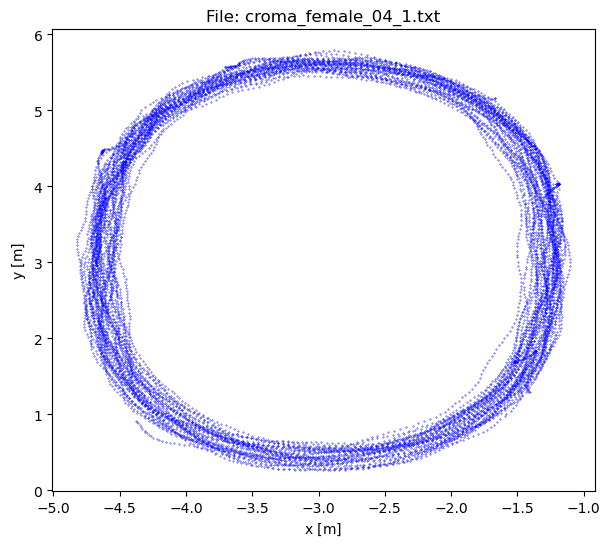

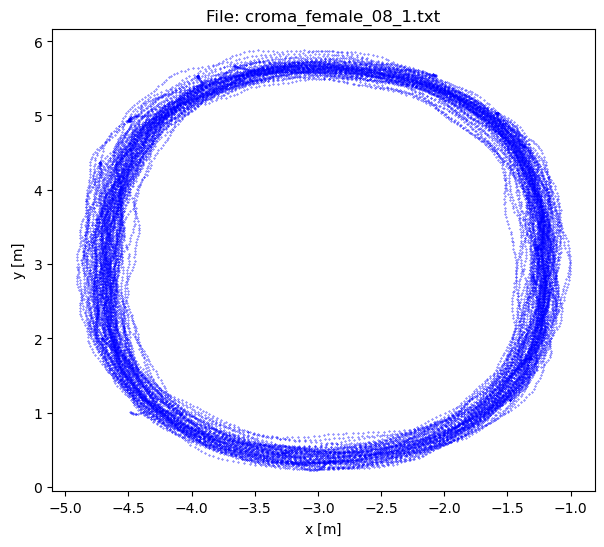

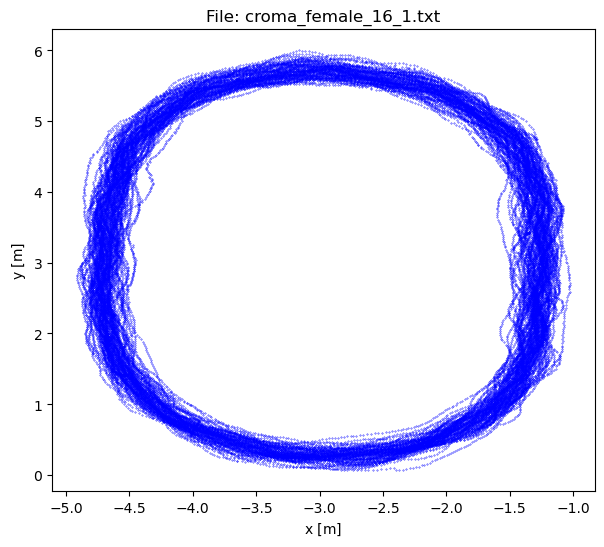

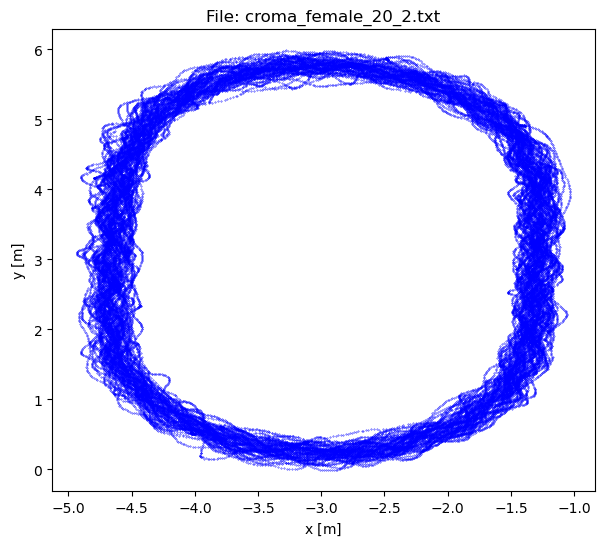

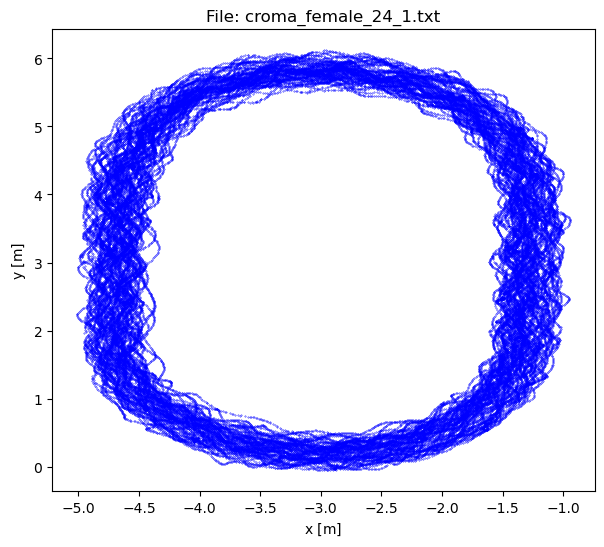

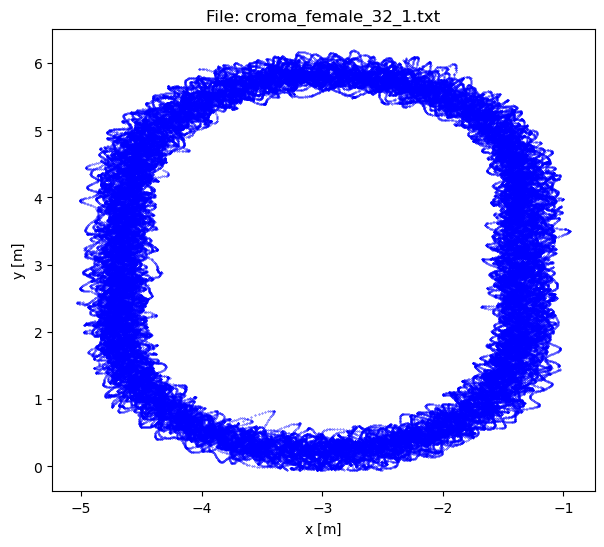

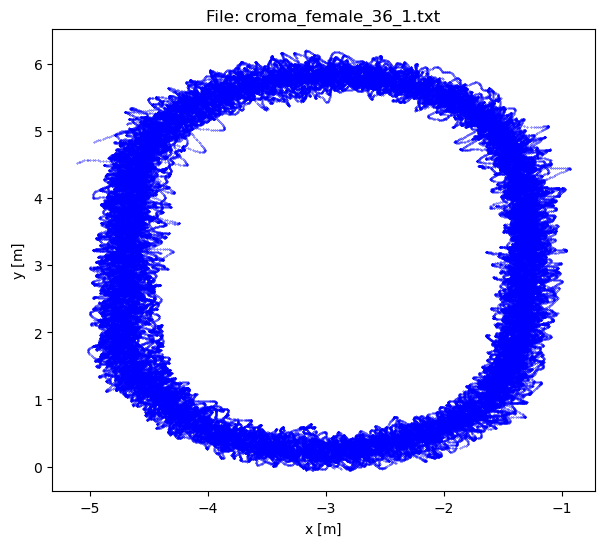

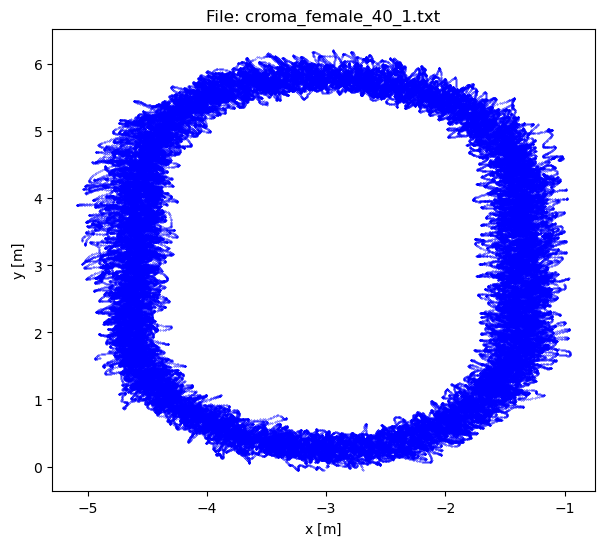

In [3]:
import matplotlib.pyplot as plt
import os

# save the raw trajectories in a dictionary
dic_traj_raw={}

for file in files_traj_raw:
    # read the raw trajectories
    data_traj_raw=pd.read_csv(path_traj_raw+"/"+file,
                              comment="#",
                              delimiter=" ",
                              names=["ID","frame","x(m)","y(m)","z(m)","markerID"])

    # save the raw trajectories in a dictionary 
    dic_traj_raw[file]=data_traj_raw
    
    # plot the raw trajectories
    fig = plt.figure(figsize=(7, 6))
    plt.plot(data_traj_raw['x(m)'], data_traj_raw['y(m)'], "bo", markersize=0.3)
    plt.title(f'File: {file}')
    plt.xlabel(r"$\rm x~[m]$")
    plt.ylabel(r"$\rm y~[m]$")
    plt.show()

### Apply the transformation additional

Upon observing the raw trajectory file plots, we notice that the (x, y) values are centered around (0, 0). Different data files may have varying center points, depending on the trajectory data extraction process.

For our transformation of oval trajectories to straight trajectories, we follow the same method as [Ziemer et al.](http://arxiv.org/abs/1602.03053) (refer to the following Figure). Thus, we need to adjust the trajectories in the new coordinate system, which corresponds to a person starting to walk from the beginning of the bottom straight corridor at x=0 along the middle line of the corridor (y=0). Additionally, the direction of pedestrians' movement should be counterclockwise; if it is clockwise, a horizontal reflection should be applied.

<p align="center">
    <img src="/home/rudinasbaih/Documents/SingleFileMovementAnalysis/notebooks/demo_data/new_coordinate_system_ziemer.png">
</p>

First, we need to apply the proper transformation (i.e., rotate, shift-up, shift-left). We store the transformation data for the available single-file experiments in the data class [experiments.py](../helper/experiments.py), along with other data required for the analysis.

> **NOTE:** the user can save the new transformation data as an object in the [experiments.py](../helper/experiments.py) data class as the following example:
```py
    "genderCroMa_setupLeft_germany_paetzke": ExperimentData(
        link_data="empty",
        delimiter='\t',
        shift_x=-1.7,
        shift_y=-1.3,
        ref_y=-1,
        x_rotate=3,
        y_rotate=2,
        fps=25,
        length=2.3,
        radius=1.65,
        circumference=14.97,
        camera_capture=0
    )
``` 
or choose one of the stored objects:

In [4]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..', 'helper'))+'/')
from experiments import EXPERIMENTS

# the key of the experiment (object from class data) that stores the experiment attributes important for transformation and analysis
exp_key="genderCroMa_setupLeft_germany_paetzke" 
e = EXPERIMENTS[exp_key]

Now, apply the transformation of the additional function:

In [5]:
min = e.Min
max = e.Max
unit = e.unit

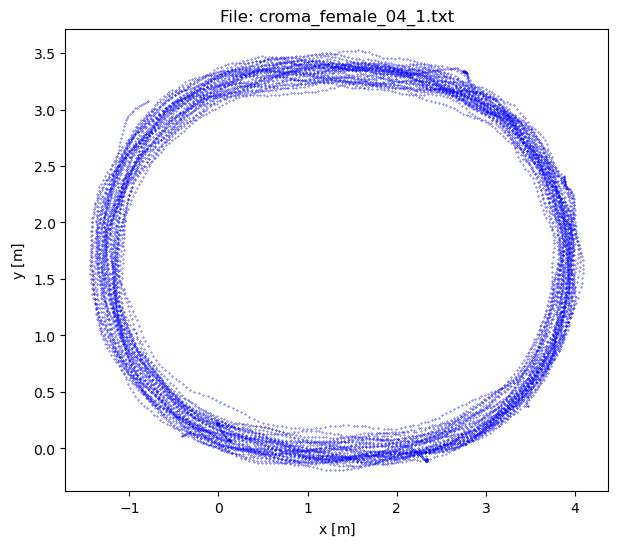

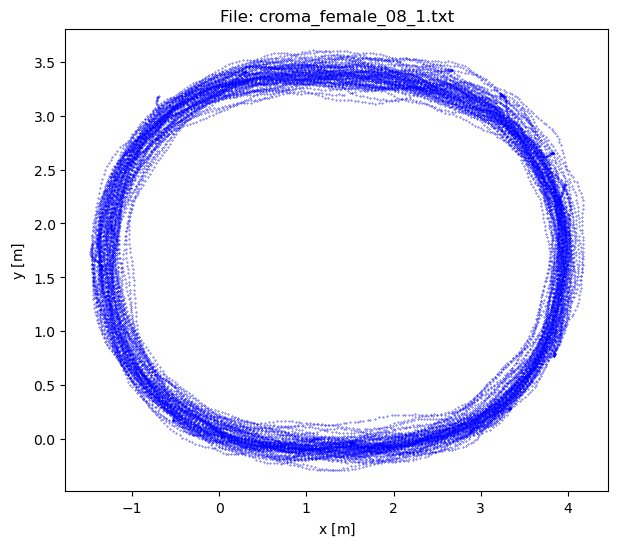

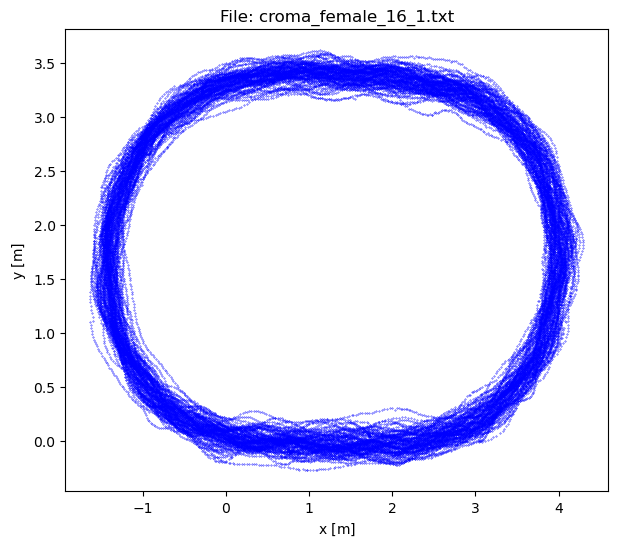

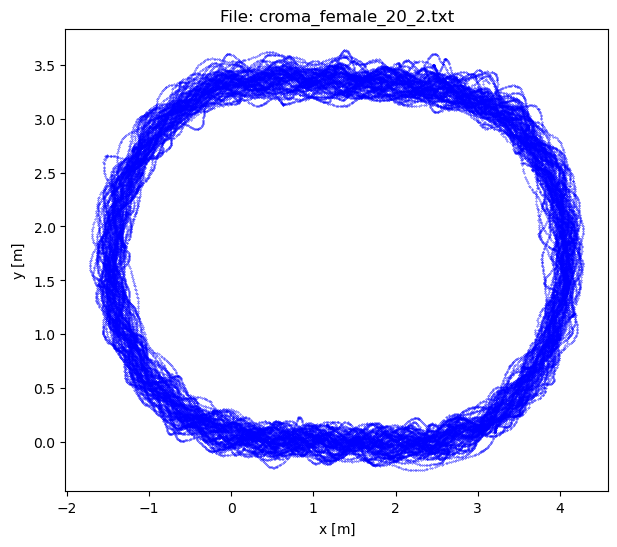

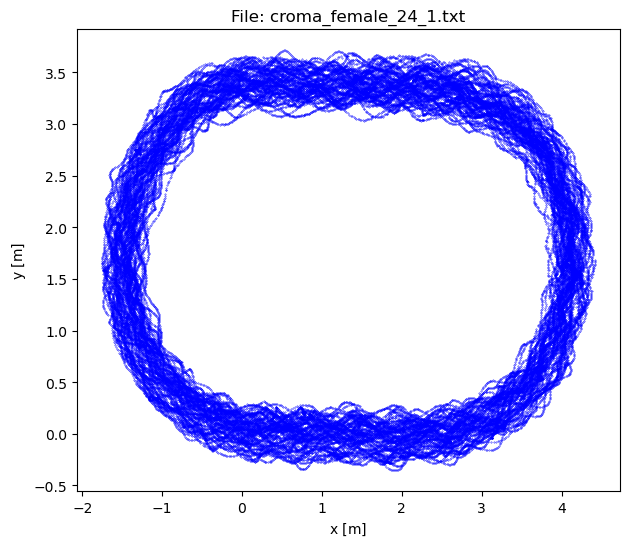

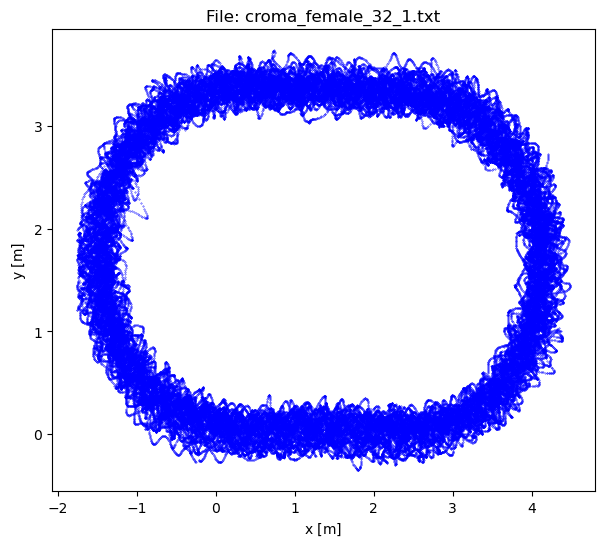

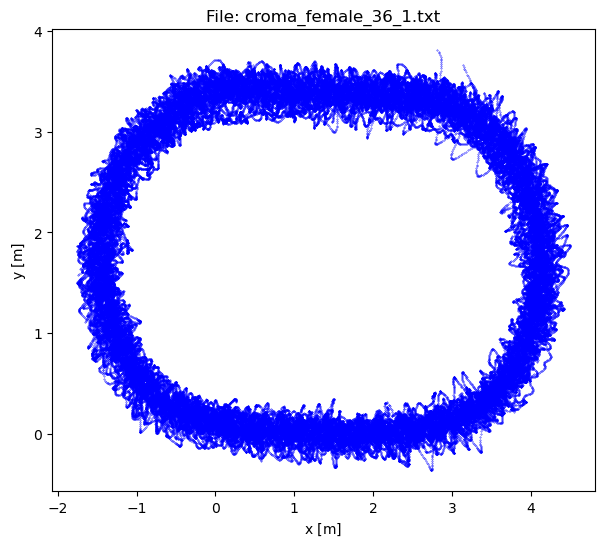

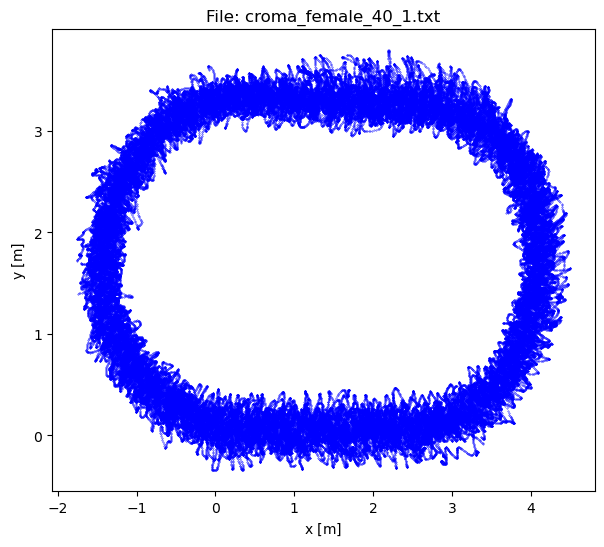

In [6]:
from helper import process_data

# transformation additional dictionary
dict_transformation_additional= {}

for key in dic_traj_raw.keys():
    # read the raw trajectories
    data_traj_raw=dic_traj_raw[key]
    # setup coordination system transformation
    x_y_transformed = process_data(data_traj_raw[["x(m)","y(m)"]].to_numpy(), exp_key)
    # update the data with the transformed coordinates
    data_traj_tranformed = data_traj_raw.copy()
    data_traj_tranformed[["x(m)","y(m)"]]=pd.DataFrame(x_y_transformed, columns=["x(m)","y(m)"])

    if (min is not None) and (max is not None):  # data inside measurement area (unique for each experiment)
        data_traj_tranformed = data_traj_tranformed[((data_traj_tranformed['x(m)'] / unit) >= min) & ((data_traj_tranformed['y(m)'] / unit) <= max)]

    # save the transformed trajectories to dictionary
    dict_transformation_additional[key] = data_traj_tranformed

    # plot the transformed trajectories
    fig = plt.figure(figsize=(7, 6))
    plt.plot(data_traj_tranformed["x(m)"], data_traj_tranformed["y(m)"], "bo", markersize=0.3)
    plt.title(f'File: {key}')
    plt.xlabel(r"$\rm x~[m]$")
    plt.ylabel(r"$\rm y~[m]$")
    plt.show()

### Apply the transformation straight to the data

Now, we will convert the oval trajectories to straight trajectories.

First, retrieve the following arguments using the object ``` EXPERIMENTS[exp_key] ```:
- ```corridor_straight_length```: length of the straight part of the corridor.
- ```corridor_length```: length of the whole corridor (oval circumference).
- ```corridor_radius```: radius of the curved part of the corridor:
- ```fps```: number of frames per second that the camera captures.

In [7]:
corridor_straight_length = e.length
corridor_length = e.circumference
corridor_radius = e.radius
fps=e.fps

Second, we apply the function ``` transformation_coord(...) ``` to transform the coordinates to straight:

In [8]:
print(dict_transformation_additional['croma_female_04_1.txt'])

       ID  frame      x(m)     y(m)  z(m)  markerID
0       1      0 -0.787231  3.07926  1.77       761
1       1      1 -0.801707  3.06664  1.77       761
2       1      2 -0.820266  3.05910  1.77       761
3       1      3 -0.842214  3.05011  1.77       761
4       1      4 -0.865486  3.03792  1.77       761
...    ..    ...       ...      ...   ...       ...
12323   4   3077  3.873660  2.38628  1.58       711
12324   4   3078  3.871840  2.39144  1.58       711
12325   4   3079  3.872280  2.40052  1.58       711
12326   4   3080  3.870360  2.40386  1.58       711
12327   4   3081  3.870520  2.40749  1.58       711

[12328 rows x 6 columns]


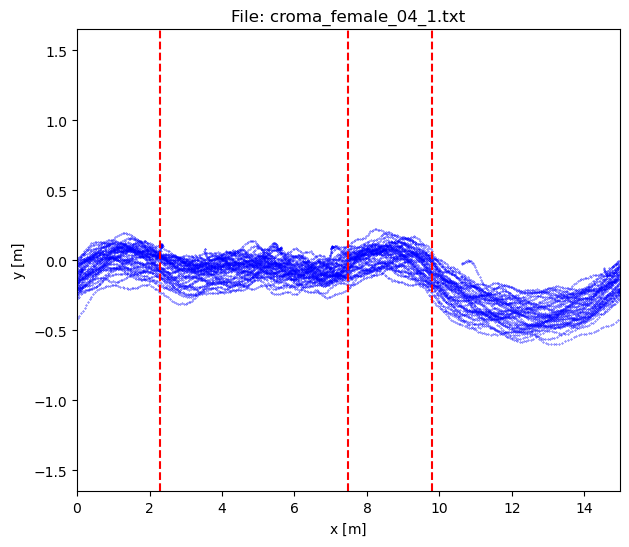

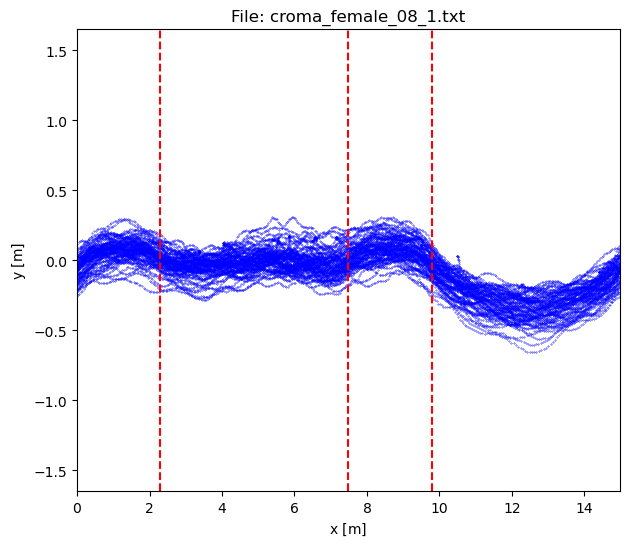

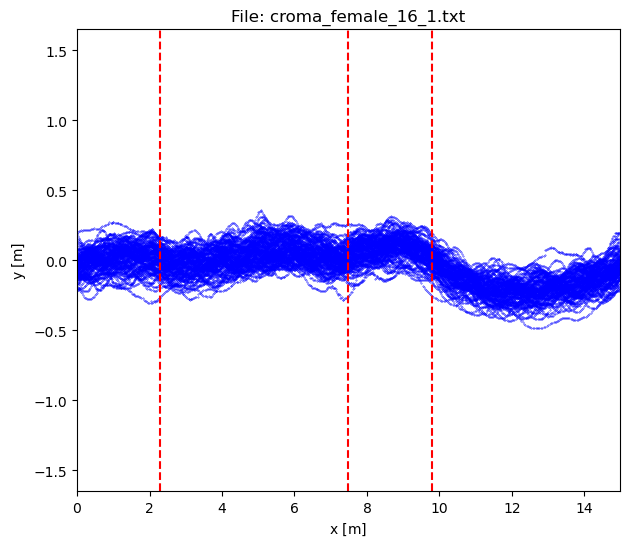

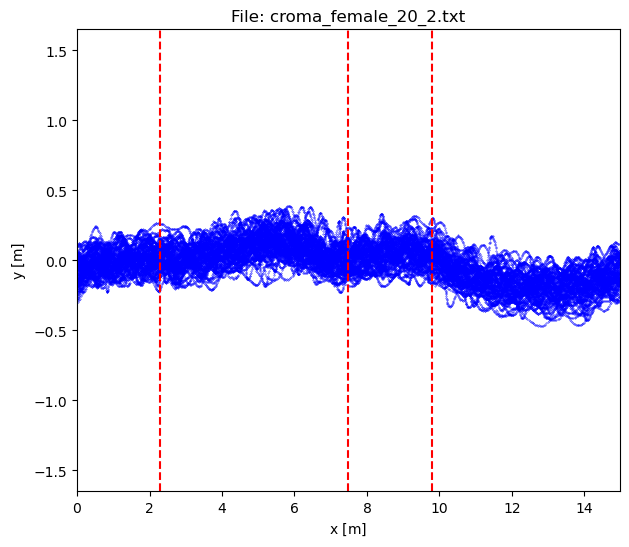

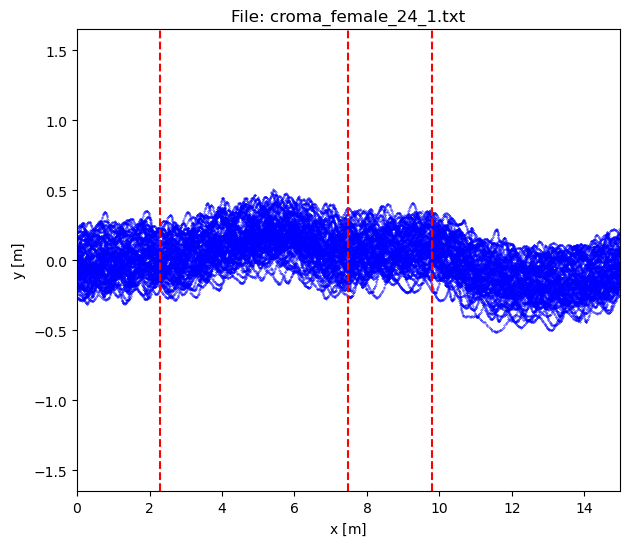

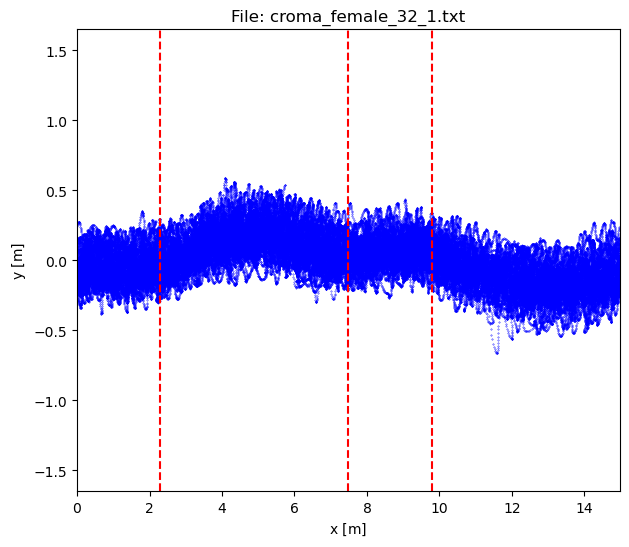

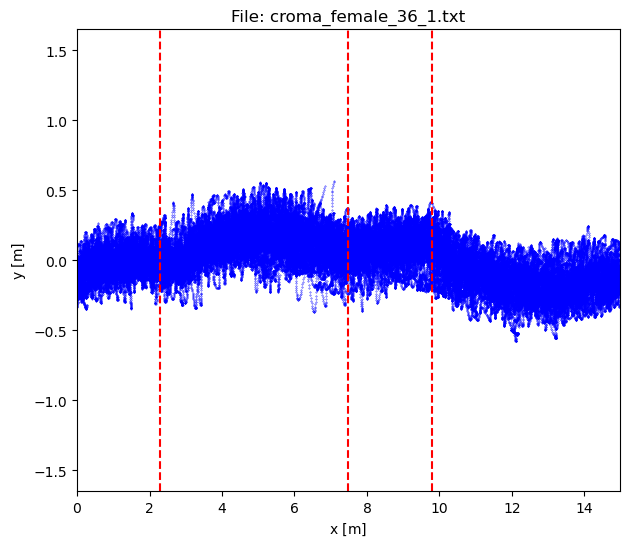

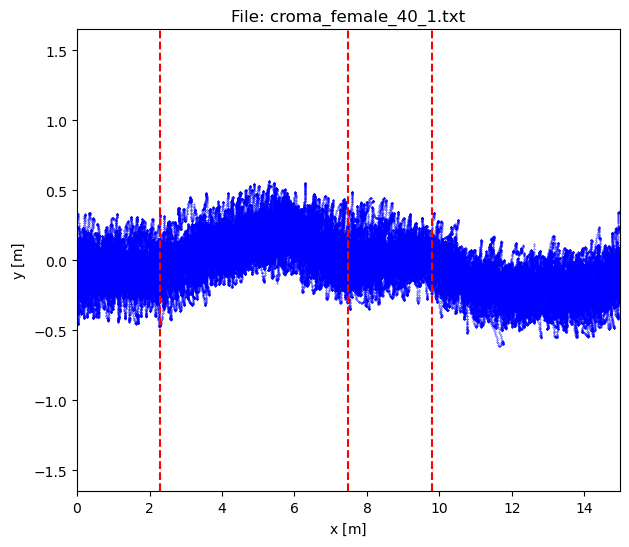

In [9]:
from helper import transformation_coord

# transformation straight dictionary
dict_transformation_straight = {}

for key in dict_transformation_additional.keys():
    # read the trandsformed additional trajectories
    data_transformation_additional = dict_transformation_additional[key]

    x_y_trans = transformation_coord(data_transformation_additional[["x(m)","y(m)"]].to_numpy(),
                                            corridor_straight_length, 
                                            corridor_radius)
    data_transformation_straight=data_transformation_additional.copy()
    data_transformation_straight['x(m)']=x_y_trans[:,0]
    data_transformation_straight['y(m)']=x_y_trans[:,1]
    dict_transformation_straight[key] = data_transformation_straight

    # plot the transformed straight trajectories
    fig = plt.figure(figsize=(7, 6))
    plt.plot(data_transformation_straight['x(m)'], 
             data_transformation_straight['y(m)'], 
             "bo", 
             markersize=0.3)
    plt.title(f'File: {key}')
    plt.xlim(0,corridor_length)
    plt.ylim(-corridor_radius,corridor_radius)
    plt.xlabel(r"$\rm x~[m]$")
    plt.ylabel(r"$\rm y~[m]$")
    plt.vlines(corridor_straight_length, -corridor_radius, corridor_radius, colors='r', linestyles='dashed')
    plt.vlines(corridor_straight_length+(2*np.pi*corridor_radius)/2, -corridor_radius, corridor_radius, colors='r', linestyles='dashed')
    plt.vlines(2*corridor_straight_length+(2*np.pi*corridor_radius)/2, -corridor_radius, corridor_radius, colors='r', linestyles='dashed')
    plt.show()

> **NOTE:** the dashed red lines indicate the parts of the oval setup (straight, curved, straight, curved).

### Plot the space-time relation

To plot the space-time relation, we need to plot the x position values from the straight trajectories data of pedestrians as follows:

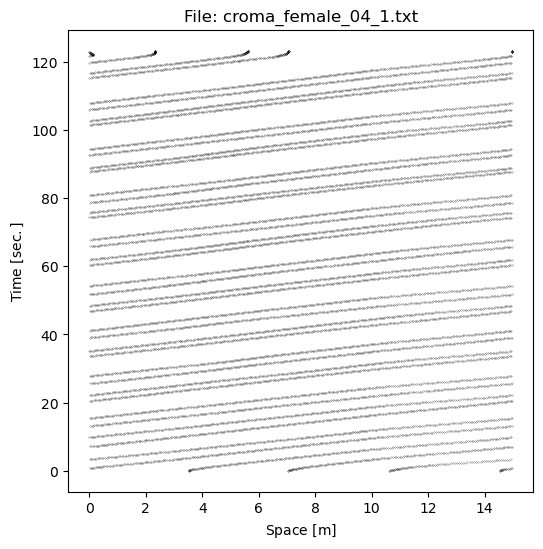

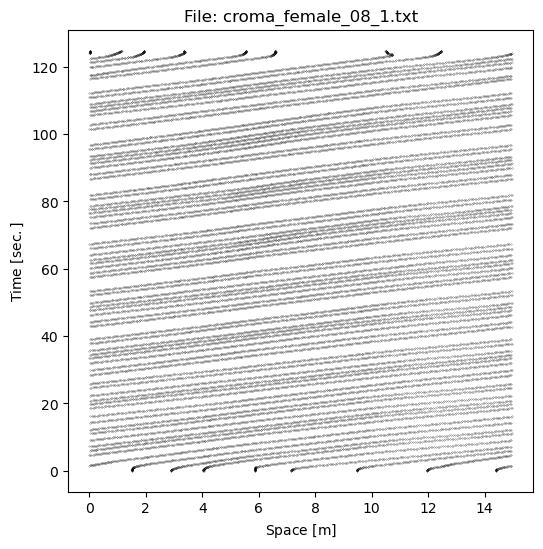

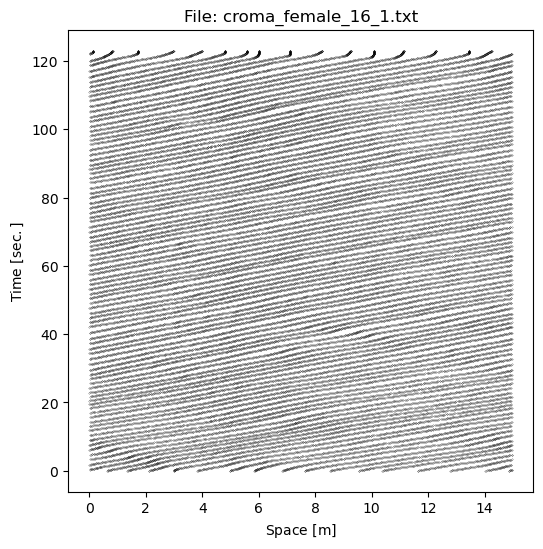

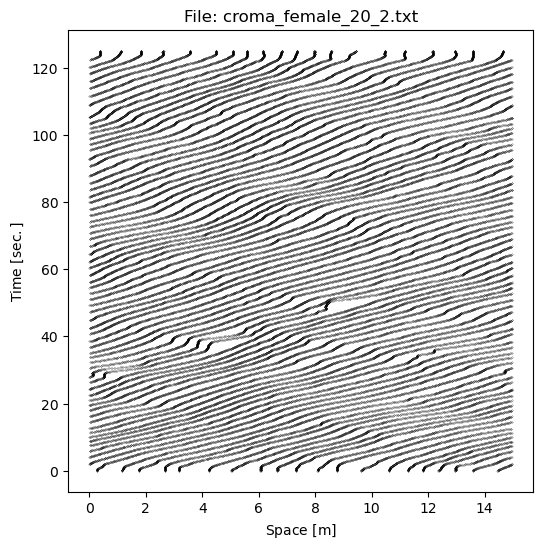

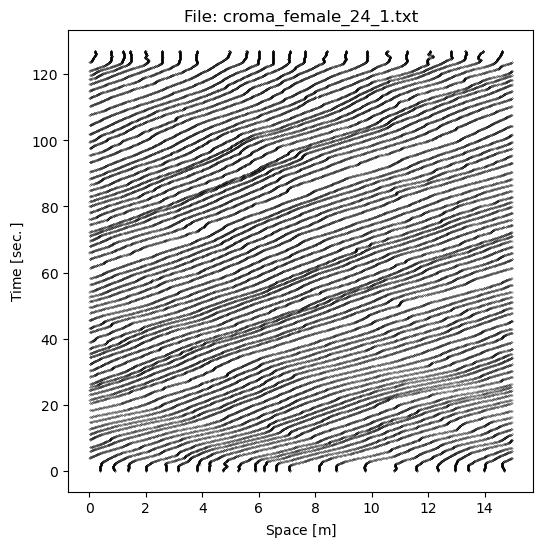

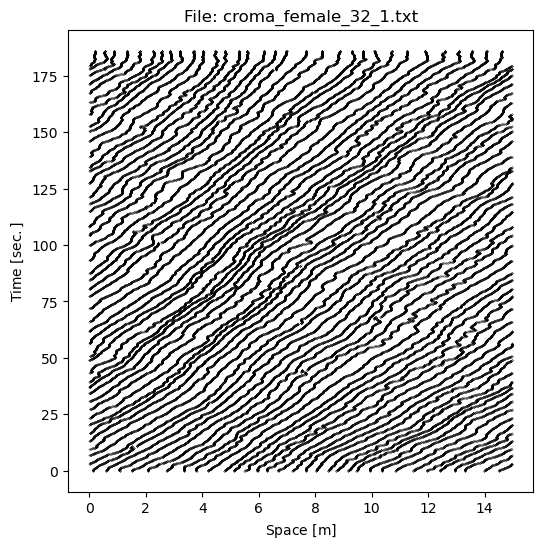

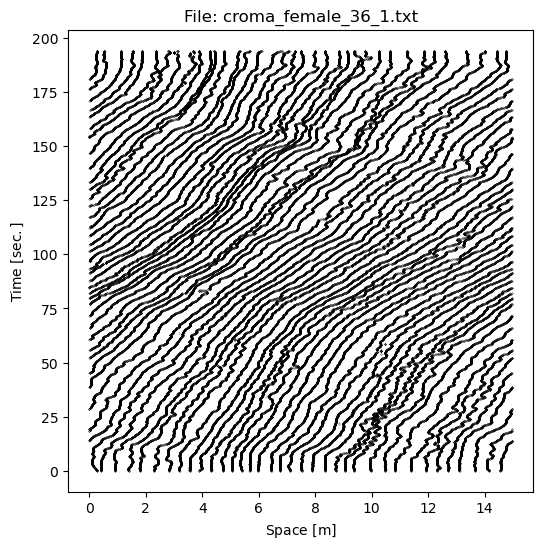

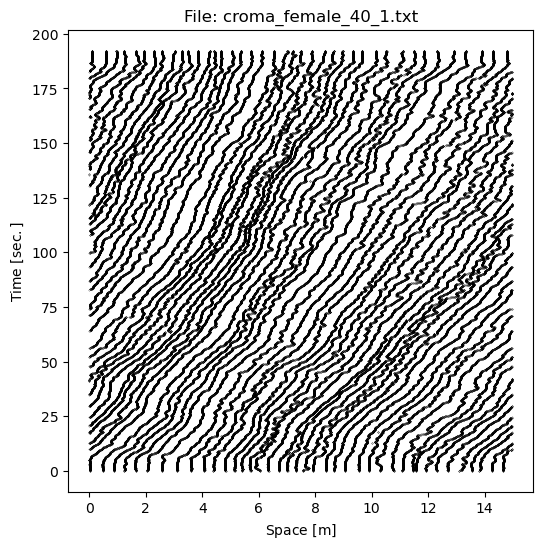

In [10]:
for key in dict_transformation_straight.keys():
    fig = plt.figure(figsize=(6, 6))

    data = dict_transformation_straight[key]
    for ped_id in set(data["ID"]):
        # Take only the trajectory for one person
        p_data = data.loc[data["ID"] == ped_id]
        plt.scatter(p_data["x(m)"], p_data["frame"] / fps, s=0.1, 
                    edgecolors="black", facecolors="black", marker=".")

    plt.title(f"File: {key}")
    plt.xlabel(r"Space [$\rm m$]")
    plt.ylabel(r"Time [$\rm sec.$]")
    plt.show()


### Calculate the speed and density of the pedestrians

Here we calculate the individual instantaneous speed and the 1D Voronoi density for each pedestrian.

First, we define the argument needed for the calculations:
- ```camera_capture```: top-view, or side-view.
- ```delta_t```: the time constant to calculate the speed.

In [11]:
camera_capture = e.camera_capture
delta_t=0.4

then, we apply the following function ```calculate_speed_density_headway(...)``` to calculate the speed, density, and headway of each pedestrian:

In [12]:
from helper import calculate_speed_density_headway

# calculate speed, density and headway
dic_speed_density_headway = {}
for key in dict_transformation_straight.keys():
    if len(key):
        data = dict_transformation_straight[key]
        new_data = np.array(data[['ID','frame','x(m)','y(m)','z(m)']])
        result = calculate_speed_density_headway(new_data,fps,corridor_length,
                                                 camera_capture,
                                                 delta_t)
        data_speed_density_headway = pd.DataFrame(result, 
                                                  columns=['ID','frame','x(m)','y(m)','z(m)','speed(m/s)','headway(s)','density(1/m)'])
    else:
        print("Warning:\tPlease enter the full path of the source file.")
    dic_speed_density_headway[key] = data_speed_density_headway

### Choose the steady state

In the single-file movement experiments we have three states of pedestrian movement: transit states (at the beginning and end of the experiment where the pedestrians increase and decrease their speed over time, respectively), and steady state (where the pedestrians' speed remains stable over time).

In this step, we need to choose the time instance where we want to apply our analysis and plot the relations (i.e. density-speed). Here we choose to apply the analysis on the steady state.

> **NOTE:** skip the "Choose the steady state" section if you intend to apply the analysis over all the states of the pedestrian movement.

First, we plot the time-speed/density relation:

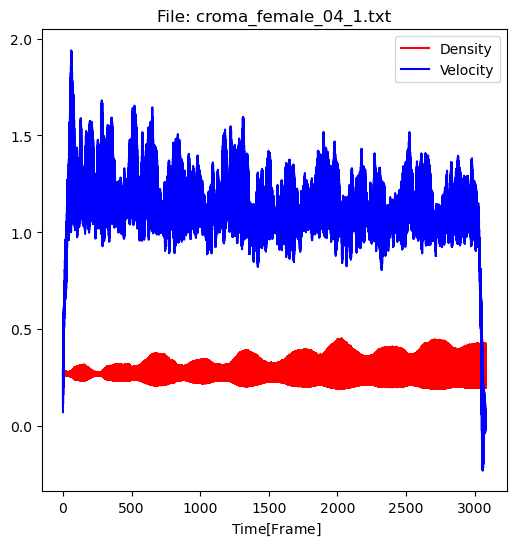

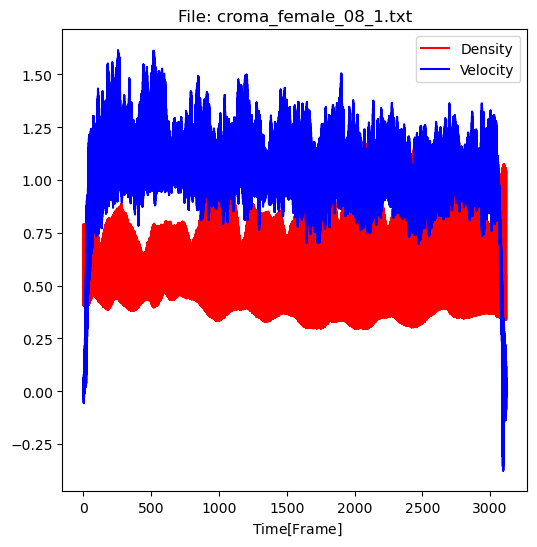

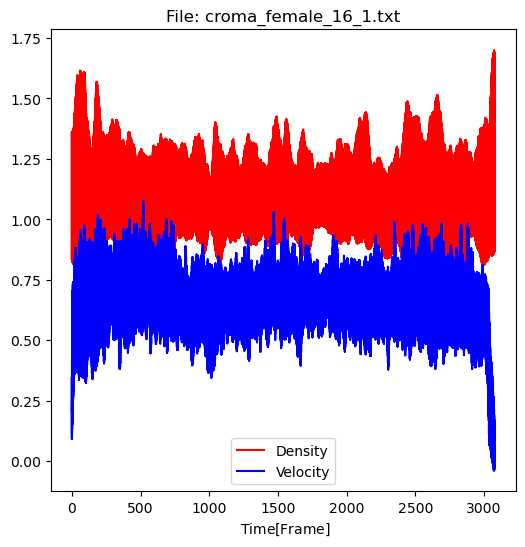

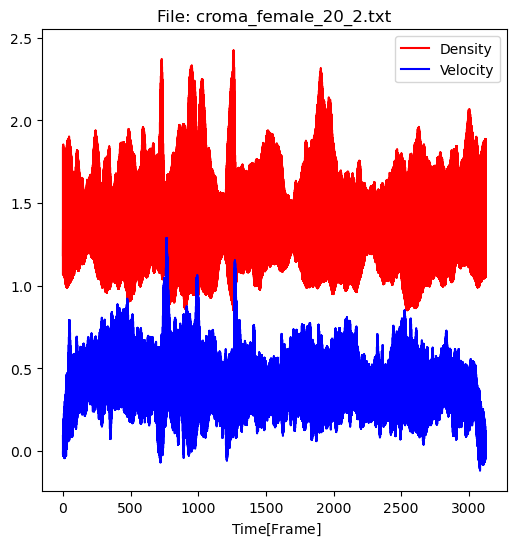

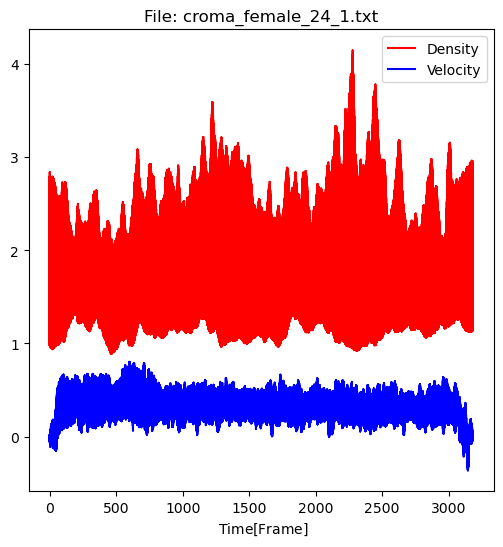

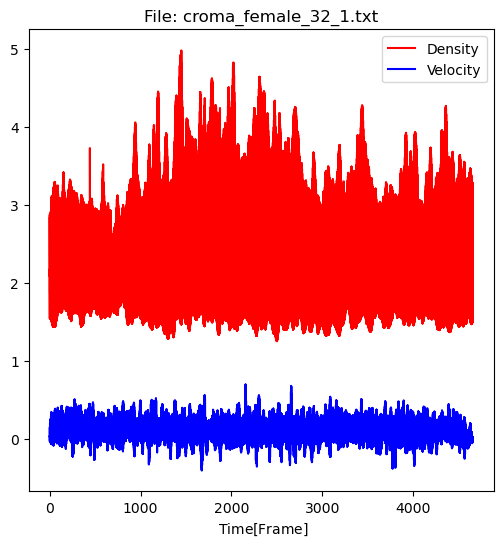

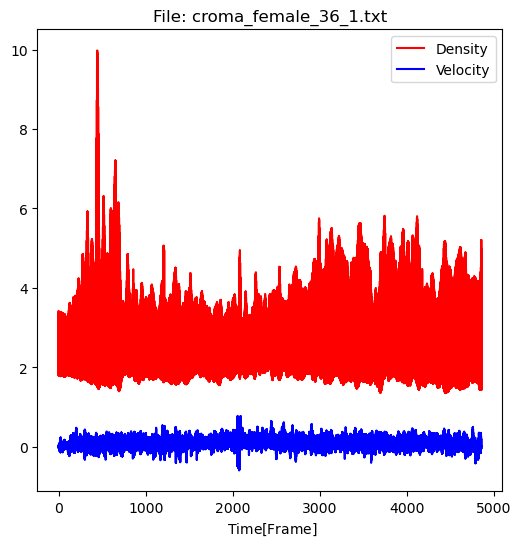

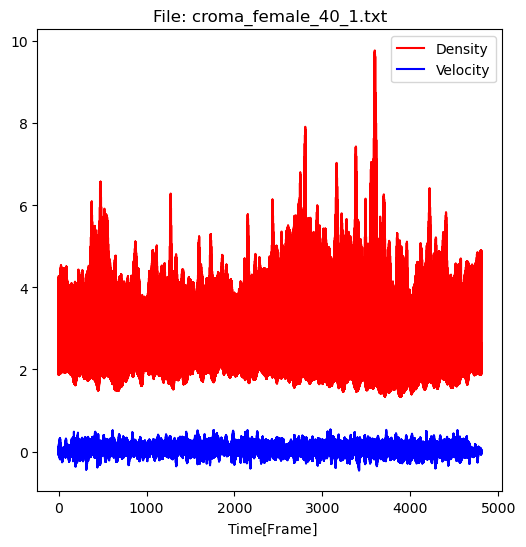

In [13]:
for key in dic_speed_density_headway.keys():
    result = dic_speed_density_headway[key]

    fig = plt.figure(figsize=(6, 6))
    plt.plot(result['frame'], result['density(1/m)'], 'r-', label="Density")
    plt.plot(result['frame'], result['speed(m/s)'], 'b-', label="Velocity")
    plt.title(f'File: {key}')
    plt.xlabel(r" $\rm Time[Frame]$")
    plt.legend()
    plt.show()

Let us take the experiment file "female_05_01.csv" to pick manually the start and end frame of the steady state:

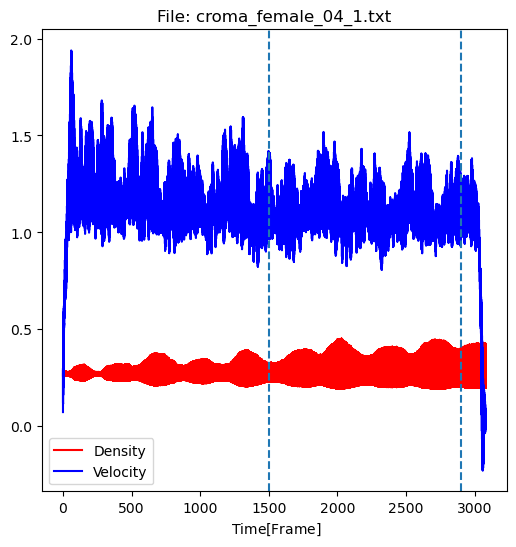

In [14]:
key="croma_female_04_1.txt"
result = dic_speed_density_headway[key]

fig = plt.figure(figsize=(6, 6))
plt.plot(result['frame'], result['density(1/m)'], 'r-', label="Density")
plt.plot(result['frame'], result['speed(m/s)'], 'b-', label="Velocity")
plt.title(f'File: {key}')
plt.xlabel(r" $\rm Time[Frame]$")
plt.legend()

st = 1500 # start time frame of the steady state
en = 2900 # end time frame of the steady state
plt.axvline(x=st, linestyle="--")
plt.axvline(x=en, linestyle="--")

plt.show()

save the start and end of all experiments' steady states in the following argument:

In [15]:
starts=[1500,1500,500,1500,600,2600,1000,600]
ends=[2900,3000,2580,2590,2000,4500,2990,2300]

extract the data between the steady state for all the experiments' data:

In [25]:
from helper import extract_steady_state

dic_speed_density_headway_steady_state = {}

for key, start, end in zip(dic_speed_density_headway.keys(), starts, ends):
    result = extract_steady_state(dic_speed_density_headway[key].to_numpy(), 
                                  start, 
                                  end)
    dic_speed_density_headway_steady_state[key] = pd.DataFrame(result, columns=['ID','frame','x(m)','y(m)','t(s)','speed(m/s)','headway(s)','density(1/m)'])

### Plot the fundamental diagram (density-speed)

Plot the fundamental diagram relation (density-speed). To customize the figure labels and add the experiment name as a title:

In [17]:
labels = ['Female=4', 'Female=8', 'Female=16', 'Female=20', 'Female=24', 'Female=32', 'Female=36', 'Female=40']
experiment_name="Germany_Paetzke2023"

then, to plot:

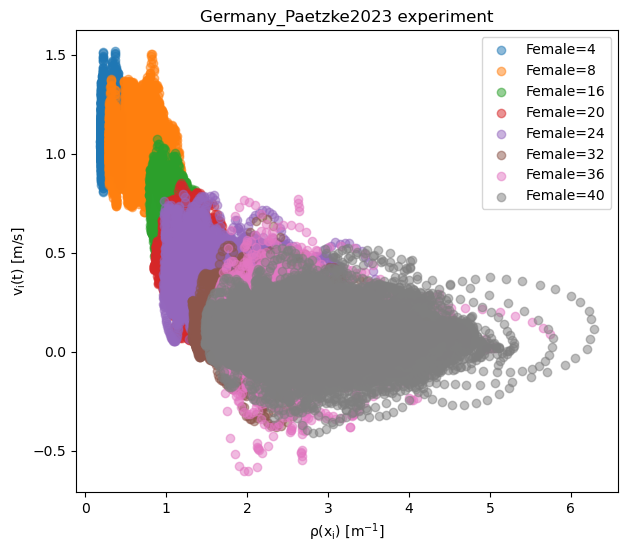

In [18]:
fig = plt.figure(figsize=(7, 6))

for key,label in zip(dic_speed_density_headway_steady_state.keys(),labels):
    data = dic_speed_density_headway_steady_state[key]
    plt.scatter(data["density(1/m)"], 
                data["speed(m/s)"], 
                label=label, 
                alpha=0.5)

plt.xlabel(r"$\rm \rho(x_{i})~[m^{-1}]$")
plt.ylabel(r"$\rm v_{i}(t)~[m/s]$")
plt.legend()
plt.title(f"{experiment_name} experiment")
plt.show()

### Plot the headway-speed relation

and to plot the headway-speed relations:

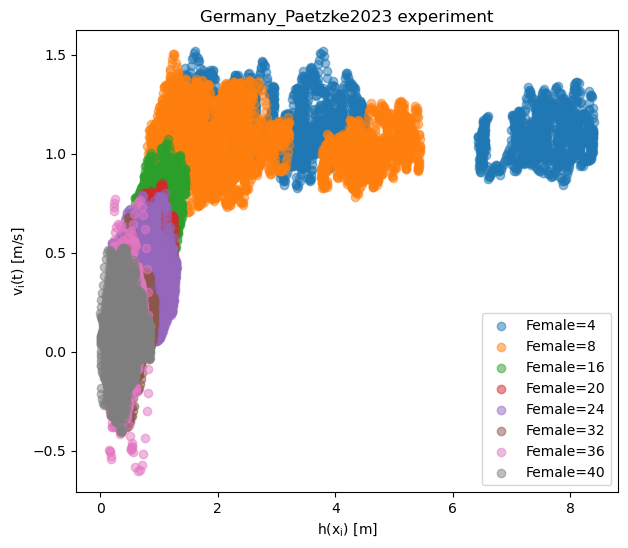

In [19]:
fig = plt.figure(figsize=(7, 6))

for key,label in zip(dic_speed_density_headway_steady_state.keys(),labels):
    data = dic_speed_density_headway_steady_state[key]
    plt.scatter(data["headway(s)"], 
                data["speed(m/s)"], 
                label=label, 
                alpha=0.5)

plt.xlabel(r"$\rm h(x_{i})~[m]$")
plt.ylabel(r"$\rm v_{i}(t)~[m/s]$")
plt.legend()
plt.title(f"{experiment_name} experiment")
plt.show()

### Save the data into files

Here is codes to save all results in a .csv files for the following:
- Trajectory transformation additional data
- Trajectory transformation straight data
- Density, speed, and headway data

First, choose the path of the directory to save the outputs:

In [20]:
path_output="../notebooks/demo_data/genderFemale_germany_paetzke2023"

Then, save the trajectory data of transformation additional:

In [21]:
for key in dict_transformation_additional.keys():
    data = dict_transformation_additional[key]
    if not os.path.exists(path_output+"/traj/02_transformation_additional/"):
        os.makedirs(path_output+"/traj/02_transformation_additional/")
    data.to_csv(path_output+"/traj/02_transformation_additional/"+key, 
                sep='\t',
                index=False)

Save the trajectory data of transformation straight:

In [22]:
for key in dict_transformation_straight.keys():
    data = dict_transformation_straight[key]
    if not os.path.exists(path_output+"/traj/03_transformation_straight/"):
        os.makedirs(path_output+"/traj/03_transformation_straight/")
    data.to_csv(path_output+"/traj/03_transformation_straight/"+key, 
                sep='\t',
                index=False)

Save the caclulated movement quantities (density,speed, headway):

In [23]:
for key in dic_speed_density_headway.keys():
    data = dic_speed_density_headway[key]
    if not os.path.exists(path_output+"/rho_vel_headway/"):
        os.makedirs(path_output+"/rho_vel_headway/")
    data.to_csv(path_output+"/rho_vel_headway/"+key, 
                sep='\t',
                index=False)

Save the caclulated movement quantities (density,speed, headway) in the 
steady state:

In [24]:
for key in dic_speed_density_headway_steady_state.keys():
    data = dic_speed_density_headway_steady_state[key]
    if not os.path.exists(path_output+"/rho_vel_headway/steady_state_data/"):
        os.makedirs(path_output+"/rho_vel_headway/steady_state_data/")
    data.to_csv(path_output+"/rho_vel_headway/steady_state_data/"+key, 
                sep='\t',
                index=False)